In [ ]:
# Transfer Learning com VGG16 - Imagens de Alta Resolução
## Classificação de Retinopatia Diabética

Este notebook demonstra o conceito de **Transfer Learning** usando uma VGG16 pré-treinada na ImageNet para classificar condições oculares.

### Conceito de Transfer Learning
Transfer Learning é uma técnica onde utilizamos um modelo pré-treinado em um grande dataset (como ImageNet) e adaptamos suas características aprendidas para nossa tarefa específica. Isso é especialmente útil quando:
- Temos um dataset menor
- Queremos acelerar o treinamento
- Queremos aproveitar características já aprendidas

### Experimento
Nesta primeira parte, vamos treinar apenas com **imagens de alta resolução** (sem prefixos '50_' e '80ses').


In [10]:
# Imports baseados no código original
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# TensorFlow/Keras imports (seguindo cam_models.py)
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, Dense, Layer
from tensorflow.keras.metrics import AUC, BinaryAccuracy
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponível: {tf.config.list_physical_devices('GPU')}")

# Definir métricas (como no código original)
metrics = [BinaryAccuracy(name="accuracy"), AUC(name="auc")]


TensorFlow version: 2.20.0
GPU disponível: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [11]:
# GlobalAveragePooling personalizado (exatamente como no cam_models.py)
@tf.keras.utils.register_keras_serializable()
class GlobalAveragePooling(Layer):
    def __init__(self, **kwargs):
        super(GlobalAveragePooling, self).__init__(**kwargs)

    def call(self, inputs):
        return K.mean(inputs, axis=(2, 3))

    def compute_output_shape(self, input_shape):
        return input_shape[0:2]

    def get_config(self):
        base_config = super(GlobalAveragePooling, self).get_config()
        return base_config

print("✅ GlobalAveragePooling customizado definido")


✅ GlobalAveragePooling customizado definido


In [12]:
# Configuração (baseada no Config original mas adaptada para alta resolução)
class ConfigAlta:
    def __init__(self):
        # Dataset e caminhos
        self.ds = 'unifesp_classificadas'
        self.patologia = 'rd'  # retinopatia diabética
        self.source = f'data/{self.ds}/'
        self.dest = f'data/{self.ds}/algo/'
        
        # Parâmetros do modelo (seguindo o código original)
        self.n_layers = 5
        self.type_train = 'n'  # normal (transfer learning da ImageNet)
        self.epochs = 30
        self.batch_size = 32
        self.target_size = 299
        self.input_shape = (299, 299, 3)
        self.lr = 0.01
        
        # Prefixos para identificar qualidade (como no código original)
        self.hq = ['20sus', '021sus', '60sus', '70sus', '80sus', '30_', '60ses', '70ses', '80ses']
        self.lq = ['50_', '80ses_']  # baixa qualidade
        self.type_img = 'h'  # alta resolução
        
        # Caminhos das imagens
        self.path_normais = os.path.join(self.source, 'normais')
        self.path_patologia = os.path.join(self.source, 'alteradas', self.patologia)

cfg = ConfigAlta()
print(f"✅ Configuração carregada:")
print(f"   • Dataset: {cfg.ds}")
print(f"   • Patologia: {cfg.patologia}")
print(f"   • Tipo de imagem: {'Alta resolução' if cfg.type_img == 'h' else 'Baixa resolução'}")
print(f"   • Camadas treináveis: {cfg.n_layers}")
print(f"   • Épocas: {cfg.epochs}")
print(f"   • Batch size: {cfg.batch_size}")


✅ Configuração carregada:
   • Dataset: unifesp_classificadas
   • Patologia: rd
   • Tipo de imagem: Alta resolução
   • Camadas treináveis: 5
   • Épocas: 30
   • Batch size: 32


In [13]:
# Função __gen_df (baseada no código original load_data.py)
def gen_df(label, path):
    """Generate a dataframe with the files and the label
    :param label: label of the files
    :param path: path to the files
    :return: dataframe with the files and the label
    """
    files = [f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    file_and_label = [[os.path.join(path, f), label] for f in files]
    df = pd.DataFrame(file_and_label, columns=["filename", "label"])
    return df

# Função para filtrar apenas imagens de alta resolução
def filtrar_alta_resolucao(df, prefixos_baixa_qualidade):
    """Filtra dataframe mantendo apenas imagens de alta resolução"""
    def is_alta_qualidade(filename):
        basename = os.path.basename(filename)
        return not any(basename.startswith(prefixo) for prefixo in prefixos_baixa_qualidade)
    
    df_filtrado = df[df['filename'].apply(is_alta_qualidade)].copy()
    return df_filtrado.reset_index(drop=True)

# Carregar dados (seguindo a lógica do train.py)
print("📂 Carregando dados...")
df_pato = gen_df(cfg.patologia, cfg.path_patologia)
df_norm = gen_df('normais', cfg.path_normais)

print(f"   • Imagens {cfg.patologia} (total): {len(df_pato)}")
print(f"   • Imagens normais (total): {len(df_norm)}")

# Filtrar apenas alta resolução
df_pato_alta = filtrar_alta_resolucao(df_pato, cfg.lq)
df_norm_alta = filtrar_alta_resolucao(df_norm, cfg.lq)

print(f"   • Imagens {cfg.patologia} (alta resolução): {len(df_pato_alta)}")
print(f"   • Imagens normais (alta resolução): {len(df_norm_alta)}")

# Combinar dataframes (como no código original)
df = pd.concat([df_pato_alta, df_norm_alta], ignore_index=True)
print(f"   • Total de imagens de alta resolução: {len(df)}")

# Mostrar distribuição
print(f"\n📊 Distribuição das classes:")
print(df['label'].value_counts())


📂 Carregando dados...
   • Imagens rd (total): 6877
   • Imagens normais (total): 23220
   • Imagens rd (alta resolução): 4775
   • Imagens normais (alta resolução): 17196
   • Total de imagens de alta resolução: 21971

📊 Distribuição das classes:
label
normais    17196
rd          4775
Name: count, dtype: int64


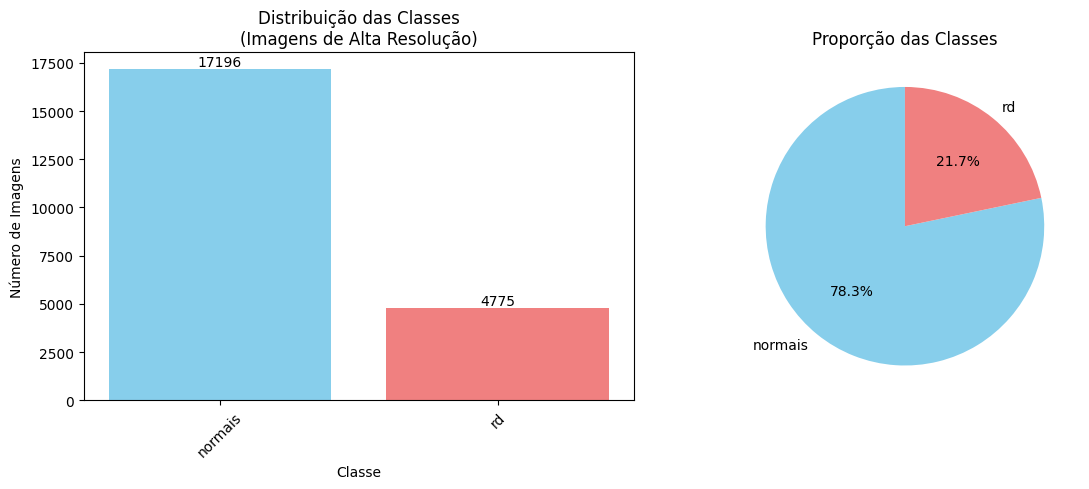


📋 Exemplos de arquivos de alta qualidade:
Imagens normais:
   70ses_19201.jpg
   20sus_64200000020002.jpg
   70ses_521402.jpg

Imagens com rd:
   20sus_64200000020002.jpg
   20sus_81100000010001.jpg
   70ses_85104.jpg


In [14]:
# Visualizar distribuição das classes
plt.figure(figsize=(12, 5))

# Gráfico de barras
plt.subplot(1, 2, 1)
contagem = df['label'].value_counts()
bars = plt.bar(contagem.index, contagem.values, color=['skyblue', 'lightcoral'])
plt.title('Distribuição das Classes\n(Imagens de Alta Resolução)')
plt.xlabel('Classe')
plt.ylabel('Número de Imagens')
plt.xticks(rotation=45)

# Adicionar valores nas barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

# Gráfico de pizza
plt.subplot(1, 2, 2)
plt.pie(contagem.values, labels=contagem.index, autopct='%1.1f%%', 
        colors=['skyblue', 'lightcoral'], startangle=90)
plt.title('Proporção das Classes')

plt.tight_layout()
plt.show()

# Mostrar exemplos de nomes de arquivos
print("\n📋 Exemplos de arquivos de alta qualidade:")
print("Imagens normais:")
for nome in df_norm_alta['filename'].head(3):
    print(f"   {os.path.basename(nome)}")

print(f"\nImagens com {cfg.patologia}:")
for nome in df_pato_alta['filename'].head(3):
    print(f"   {os.path.basename(nome)}")


In [15]:
# Função build_vgg16_GAP (exatamente como no cam_models.py)
def build_vgg16_GAP(n_layers=12, type_train="n", model_name="_raw", input_shape=(299, 299, 3), lr=0.01):
    """
    Atualmente o modelo mais eficiente na deteccao das retinopatias.
    Consiste de layers de uma VGG16 treinados no conjunto de
    dados imagenet

    :param n_layers: numero de layers que serao treinados
    :param type_train: tipo de treino que sera feito (normal 'n' or tranfer learning 'tl')
    :param model_name: nome do modelo base seja ele um treino normal ou uma transferencia de conhecimento
    :param input_shape: shape da imagem de entrada

    :return: modelo VGG16 com GAP
    """

    # Se o tipo de treino for normal, iremos fazer a transferencia de conhecimento apenas da ImageNet
    # Caso for FT, treinamos todas as layers do modelo com LR baixo
    # Caso for uma transferencia de conhecimento, frizar algumas layers e treinar em cima das demais com dados novos

    # ----------------------------- #
    if type_train == "n":
        print("Generating model with ImageNet weights")
        vgg_conv = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)

        x = vgg_conv.output
        x = GlobalAveragePooling()(x)
        predictions = Dense(2, activation="softmax", kernel_initializer="uniform")(x)

        model = Model(inputs=vgg_conv.input, outputs=predictions)
    else:
        print("Loading the base model to " + type_train)
        model = load_model(model_name + ".hdf5")
        model_name = model_name + "_" + type_train

    # ----------------------------- #
    count = 0
    # Unlock all layers for transfer learning with specific LR
    if type_train == "tl":
        for layer in model.layers[::-1]:
            layer.trainable = True
        lr = 0.0001
    else:
        for layer in model.layers[::-1]:
            if not isinstance(layer, Conv2D) or count > n_layers:
                layer.trainable = False
            else:
                layer.trainable = True
                count = count + 1

    lr_schedule = ExponentialDecay(
        initial_learning_rate=lr, decay_steps=100000, decay_rate=0.96, staircase=True
    )

    opt = SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)

    model.summary()
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=metrics)

    return model, model_name

print("✅ Função build_vgg16_GAP definida (idêntica ao código original)")


✅ Função build_vgg16_GAP definida (idêntica ao código original)


In [16]:
# Funções para geração de dados (baseadas no load_data.py)
def gen_generator(cfg, train_dtgen, df):
    """Generate a generator to train the model
    :param cfg: Config class
    :param train_dtgen: ImageDataGenerator object
    :param df: dataframe with the files and the labels
    :return: generator
    """
    gen = train_dtgen.flow_from_dataframe(
        df,
        x_col="filename",
        y_col="label",
        target_size=(cfg.target_size, cfg.target_size),
        batch_size=cfg.batch_size,
        class_mode="categorical",
        interpolation="nearest",
    )
    return gen

def gen_data_kfold(cfg, df, train_idx, val_idx):
    """Generate data for a specific fold in K-fold cross-validation.
    :param cfg: Config class
    :param df: dataframe with the files and the labels
    :param train_idx: indices for the training data
    :param val_idx: indices for the validation data
    :return: train_gen and val_gen
    """
    train_dtgen = ImageDataGenerator(fill_mode="nearest")
    val_dtgen = ImageDataGenerator(fill_mode="nearest")

    train_df = df.iloc[train_idx].reset_index(drop=True)
    val_df = df.iloc[val_idx].reset_index(drop=True)

    train_gen = gen_generator(cfg, train_dtgen, train_df)
    val_gen = gen_generator(cfg, val_dtgen, val_df)

    return train_gen, val_gen

print("✅ Funções de geração de dados definidas (baseadas no código original)")


✅ Funções de geração de dados definidas (baseadas no código original)


In [17]:
# TREINAMENTO (seguindo exatamente a lógica do train.py)
print("🚀 INICIANDO TREINAMENTO COM K-FOLD CROSS-VALIDATION")
print("=" * 60)

# Extract labels for stratification (como no código original)
labels = df['label'].values

# Define the K-fold cross-validator (como no código original)
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

results = []
fold_var = 1

# Criar diretórios se não existirem
os.makedirs(f'results/{cfg.ds}', exist_ok=True)
os.makedirs(f'models/{cfg.ds}', exist_ok=True)

# Start the K-fold cross-validation loop (exatamente como no train.py)
for train_idx, val_idx in skf.split(np.zeros(len(labels)), labels):
    print(f"\n🔄 Training on fold {fold_var}")
    
    # Generate data for the current fold
    train_gen, val_gen = gen_data_kfold(cfg, df, train_idx, val_idx)
    
    print(f"   • Treino: {train_gen.samples} amostras")
    print(f"   • Validação: {val_gen.samples} amostras")
    print(f"   • Classes: {train_gen.class_indices}")
    
    # Build and compile a fresh model for each fold (como no código original)
    model_name = f"{cfg.patologia}_alta_resolucao_{str(cfg.n_layers)}_fold{fold_var}"
    model, _ = build_vgg16_GAP(cfg.n_layers, cfg.type_train, model_name, cfg.input_shape, cfg.lr)
    
    # Configurar callbacks (exatamente como no código original - SEM ReduceLROnPlateau)
    filename = model_name + '.csv'
    csv_log = callbacks.CSVLogger(f'results/{cfg.ds}/{filename}', separator=',', append=False)
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min')
    file_path = f'models/{cfg.ds}/{model_name}.keras'
    checkpoint = callbacks.ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    callb_list = [csv_log, checkpoint, early_stopping]
    
    # Compute class weights for the current fold (como no código original)
    class_weights = class_weight.compute_class_weight(
        'balanced',
        classes=np.unique(train_gen.classes),
        y=train_gen.classes
    )
    class_weights_dict = dict(enumerate(class_weights))
    print(f"   • Pesos das classes: {class_weights_dict}")
    
    # Fit the model (exatamente como no train.py)
    history = model.fit(
        train_gen,
        steps_per_epoch=train_gen.samples // cfg.batch_size,
        validation_data=val_gen,
        validation_steps=val_gen.samples // cfg.batch_size,
        epochs=cfg.epochs,
        callbacks=callb_list,
        class_weight=class_weights_dict
    )
    
    # Evaluate the model on the validation set and store metrics if needed
    result = model.evaluate(val_gen, steps=val_gen.samples // cfg.batch_size)
    results.append(result)
    print(f"   • Resultado do fold {fold_var}: {result}")
    
    # Clean up after each fold to save memory
    del model
    
    fold_var += 1

# Calculate average result (como no código original)
average_result = np.mean(results, axis=0)
print(f"\n🎯 RESULTADO FINAL:")
print(f"   • Média dos {n_splits} folds: {average_result}")
print("=" * 60)


🚀 INICIANDO TREINAMENTO COM K-FOLD CROSS-VALIDATION

🔄 Training on fold 1
Found 17576 validated image filenames belonging to 2 classes.
Found 4395 validated image filenames belonging to 2 classes.
   • Treino: 17576 amostras
   • Validação: 4395 amostras
   • Classes: {'normais': 0, 'rd': 1}
Generating model with ImageNet weights


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 299, 299, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 299, 299, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 149, 149, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 149, 149, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 149, 149, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 74, 74, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 74, 74, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 74, 74, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 74, 74, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 37, 37, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 37, 37, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 37, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 37, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 18, 18, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_2        │ (None, 9)              │             0 │
│ (GlobalAveragePooling)          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            20 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,708 (56.13 MB)

 Trainable params: 12,979,200 (49.51 MB)

 Non-trainable params: 1,735,508 (6.62 MB)

   • Pesos das classes: {0: 0.6388485024716487, 1: 2.3005235602094243}
Epoch 1/30


/home/gabriel/projects/gabriel/luzia/luzIA-core/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


549/549 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6486 - auc: 0.6865 - loss: 0.6697
Epoch 1: val_loss improved from inf to 0.66056, saving model to models/unifesp_classificadas/rd_alta_resolucao_5_fold1.keras
549/549 ━━━━━━━━━━━━━━━━━━━━ 44s 78ms/step - accuracy: 0.6487 - auc: 0.6867 - loss: 0.6698 - val_accuracy: 0.6889 - val_auc: 0.7795 - val_loss: 0.6606
Epoch 2/30
  1/549 ━━━━━━━━━━━━━━━━━━━━ 30s 56ms/step - accuracy: 0.6250 - auc: 0.7476 - loss: 0.7448

/home/gabriel/projects/gabriel/luzia/luzIA-core/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 0.66056 to 0.65957, saving model to models/unifesp_classificadas/rd_alta_resolucao_5_fold1.keras
549/549 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6250 - auc: 0.7476 - loss: 0.7448 - val_accuracy: 0.6859 - val_auc: 0.7743 - val_loss: 0.6596
Epoch 3/30
549/549 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7516 - auc: 0.8116 - loss: 0.5715
Epoch 3: val_loss improved from 0.65957 to 0.54887, saving model to models/unifesp_classificadas/rd_alta_resolucao_5_fold1.keras
549/549 ━━━━━━━━━━━━━━━━━━━━ 41s 74ms/step - accuracy: 0.7517 - auc: 0.8116 - loss: 0.5715 - val_accuracy: 0.7518 - val_auc: 0.8150 - val_loss: 0.5489
Epoch 4/30
  1/549 ━━━━━━━━━━━━━━━━━━━━ 31s 57ms/step - accuracy: 0.7188 - auc: 0.8311 - loss: 0.4969
Epoch 4: val_loss did not improve from 0.54887
549/549 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.7188 - auc: 0.8311 - loss: 0.4969 - val_accuracy: 0.7117 - val_auc: 0.7674 - val_loss: 0.6170
Epoch 5/30
549/549 ━━━━━━━━━━━━━━━━━━━━ 0

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 299, 299, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 299, 299, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 149, 149, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 149, 149, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 149, 149, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 74, 74, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 74, 74, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 74, 74, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 74, 74, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 37, 37, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 37, 37, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 37, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 37, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 18, 18, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_3        │ (None, 9)              │             0 │
│ (GlobalAveragePooling)          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            20 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,708 (56.13 MB)

 Trainable params: 12,979,200 (49.51 MB)

 Non-trainable params: 1,735,508 (6.62 MB)

   • Pesos das classes: {0: 0.638838409536963, 1: 2.30065445026178}
Epoch 1/30


/home/gabriel/projects/gabriel/luzia/luzIA-core/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


549/549 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7612 - auc: 0.8230 - loss: 0.6466
Epoch 1: val_loss improved from inf to 0.35050, saving model to models/unifesp_classificadas/rd_alta_resolucao_5_fold2.keras
549/549 ━━━━━━━━━━━━━━━━━━━━ 47s 83ms/step - accuracy: 0.7612 - auc: 0.8230 - loss: 0.6465 - val_accuracy: 0.8757 - val_auc: 0.9369 - val_loss: 0.3505
Epoch 2/30
  1/549 ━━━━━━━━━━━━━━━━━━━━ 33s 61ms/step - accuracy: 0.7812 - auc: 0.8838 - loss: 0.4207

/home/gabriel/projects/gabriel/luzia/luzIA-core/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 0.35050 to 0.34583, saving model to models/unifesp_classificadas/rd_alta_resolucao_5_fold2.keras
549/549 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7812 - auc: 0.8838 - loss: 0.4207 - val_accuracy: 0.8750 - val_auc: 0.9376 - val_loss: 0.3458
Epoch 3/30
549/549 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8508 - auc: 0.9130 - loss: 0.4129
Epoch 3: val_loss improved from 0.34583 to 0.27337, saving model to models/unifesp_classificadas/rd_alta_resolucao_5_fold2.keras
549/549 ━━━━━━━━━━━━━━━━━━━━ 44s 79ms/step - accuracy: 0.8509 - auc: 0.9130 - loss: 0.4128 - val_accuracy: 0.8978 - val_auc: 0.9557 - val_loss: 0.2734
Epoch 4/30
  1/549 ━━━━━━━━━━━━━━━━━━━━ 34s 63ms/step - accuracy: 0.9375 - auc: 0.9883 - loss: 0.2132
Epoch 4: val_loss improved from 0.27337 to 0.26523, saving model to models/unifesp_classificadas/rd_alta_resolucao_5_fold2.keras
549/549 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9375 - auc: 0.9883 - loss: 0.2132 - val_accuracy: 0.9

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 299, 299, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 299, 299, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 149, 149, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 149, 149, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 149, 149, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 74, 74, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 74, 74, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 74, 74, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 74, 74, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 37, 37, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 37, 37, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 37, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 37, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 18, 18, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_4        │ (None, 9)              │             0 │
│ (GlobalAveragePooling)          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │            20 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,708 (56.13 MB)

 Trainable params: 12,979,200 (49.51 MB)

 Non-trainable params: 1,735,508 (6.62 MB)

   • Pesos das classes: {0: 0.638838409536963, 1: 2.30065445026178}
Epoch 1/30


/home/gabriel/projects/gabriel/luzia/luzIA-core/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


549/549 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6386 - auc: 0.7338 - loss: 0.6664
Epoch 1: val_loss improved from inf to 0.76387, saving model to models/unifesp_classificadas/rd_alta_resolucao_5_fold3.keras
549/549 ━━━━━━━━━━━━━━━━━━━━ 44s 78ms/step - accuracy: 0.6386 - auc: 0.7336 - loss: 0.6664 - val_accuracy: 0.5865 - val_auc: 0.5259 - val_loss: 0.7639
Epoch 2/30
  1/549 ━━━━━━━━━━━━━━━━━━━━ 30s 56ms/step - accuracy: 0.6250 - auc: 0.4995 - loss: 0.6038

/home/gabriel/projects/gabriel/luzia/luzIA-core/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 0.76387 to 0.72156, saving model to models/unifesp_classificadas/rd_alta_resolucao_5_fold3.keras
549/549 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.6250 - auc: 0.4995 - loss: 0.6038 - val_accuracy: 0.6670 - val_auc: 0.5744 - val_loss: 0.7216
Epoch 3/30
549/549 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6969 - auc: 0.6513 - loss: 0.6449
Epoch 3: val_loss improved from 0.72156 to 0.36361, saving model to models/unifesp_classificadas/rd_alta_resolucao_5_fold3.keras
549/549 ━━━━━━━━━━━━━━━━━━━━ 40s 73ms/step - accuracy: 0.6970 - auc: 0.6515 - loss: 0.6448 - val_accuracy: 0.8755 - val_auc: 0.9366 - val_loss: 0.3636
Epoch 4/30
  1/549 ━━━━━━━━━━━━━━━━━━━━ 30s 56ms/step - accuracy: 0.9688 - auc: 0.9404 - loss: 0.2404
Epoch 4: val_loss improved from 0.36361 to 0.36080, saving model to models/unifesp_classificadas/rd_alta_resolucao_5_fold3.keras
549/549 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9688 - auc: 0.9404 - loss: 0.2404 - val_accuracy: 0.8

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 299, 299, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 299, 299, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 149, 149, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 149, 149, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 149, 149, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 74, 74, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 74, 74, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 74, 74, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 74, 74, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 37, 37, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 37, 37, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 37, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 37, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 18, 18, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_5        │ (None, 9)              │             0 │
│ (GlobalAveragePooling)          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            20 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,708 (56.13 MB)

 Trainable params: 12,979,200 (49.51 MB)

 Non-trainable params: 1,735,508 (6.62 MB)

   • Pesos das classes: {0: 0.638838409536963, 1: 2.30065445026178}
Epoch 1/30


/home/gabriel/projects/gabriel/luzia/luzIA-core/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


549/549 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8151 - auc: 0.8845 - loss: 0.5946
Epoch 1: val_loss improved from inf to 0.45837, saving model to models/unifesp_classificadas/rd_alta_resolucao_5_fold4.keras
549/549 ━━━━━━━━━━━━━━━━━━━━ 47s 83ms/step - accuracy: 0.8151 - auc: 0.8845 - loss: 0.5945 - val_accuracy: 0.7908 - val_auc: 0.8705 - val_loss: 0.4584
Epoch 2/30
  1/549 ━━━━━━━━━━━━━━━━━━━━ 34s 63ms/step - accuracy: 0.7188 - auc: 0.7427 - loss: 0.5333

/home/gabriel/projects/gabriel/luzia/luzIA-core/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 0.45837 to 0.41346, saving model to models/unifesp_classificadas/rd_alta_resolucao_5_fold4.keras
549/549 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.7188 - auc: 0.7427 - loss: 0.5333 - val_accuracy: 0.8209 - val_auc: 0.8988 - val_loss: 0.4135
Epoch 3/30
549/549 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8439 - auc: 0.9183 - loss: 0.3869
Epoch 3: val_loss improved from 0.41346 to 0.30545, saving model to models/unifesp_classificadas/rd_alta_resolucao_5_fold4.keras
549/549 ━━━━━━━━━━━━━━━━━━━━ 47s 85ms/step - accuracy: 0.8439 - auc: 0.9183 - loss: 0.3869 - val_accuracy: 0.8805 - val_auc: 0.9452 - val_loss: 0.3054
Epoch 4/30
  1/549 ━━━━━━━━━━━━━━━━━━━━ 35s 65ms/step - accuracy: 0.9062 - auc: 0.9082 - loss: 0.3740
Epoch 4: val_loss improved from 0.30545 to 0.28397, saving model to models/unifesp_classificadas/rd_alta_resolucao_5_fold4.keras
549/549 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9062 - auc: 0.9082 - loss: 0.3740 - val_accuracy: 0.

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 299, 299, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 299, 299, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 149, 149, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 149, 149, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 149, 149, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 74, 74, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 74, 74, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 74, 74, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 74, 74, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 37, 37, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 37, 37, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 37, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 37, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 18, 18, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_6        │ (None, 9)              │             0 │
│ (GlobalAveragePooling)          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │            20 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,708 (56.13 MB)

 Trainable params: 12,979,200 (49.51 MB)

 Non-trainable params: 1,735,508 (6.62 MB)

   • Pesos das classes: {0: 0.638838409536963, 1: 2.30065445026178}
Epoch 1/30


/home/gabriel/projects/gabriel/luzia/luzIA-core/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


549/549 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7457 - auc: 0.8496 - loss: 0.6035
Epoch 1: val_loss improved from inf to 0.62847, saving model to models/unifesp_classificadas/rd_alta_resolucao_5_fold5.keras
549/549 ━━━━━━━━━━━━━━━━━━━━ 52s 92ms/step - accuracy: 0.7457 - auc: 0.8496 - loss: 0.6034 - val_accuracy: 0.7156 - val_auc: 0.7761 - val_loss: 0.6285
Epoch 2/30
  1/549 ━━━━━━━━━━━━━━━━━━━━ 33s 60ms/step - accuracy: 0.6875 - auc: 0.7754 - loss: 0.5029

/home/gabriel/projects/gabriel/luzia/luzIA-core/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 0.62847 to 0.39310, saving model to models/unifesp_classificadas/rd_alta_resolucao_5_fold5.keras
549/549 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6875 - auc: 0.7754 - loss: 0.5029 - val_accuracy: 0.8488 - val_auc: 0.9144 - val_loss: 0.3931
Epoch 3/30
549/549 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8463 - auc: 0.9183 - loss: 0.3950
Epoch 3: val_loss did not improve from 0.39310
549/549 ━━━━━━━━━━━━━━━━━━━━ 42s 77ms/step - accuracy: 0.8463 - auc: 0.9184 - loss: 0.3950 - val_accuracy: 0.8123 - val_auc: 0.8779 - val_loss: 0.4596
Epoch 4/30
  1/549 ━━━━━━━━━━━━━━━━━━━━ 29s 54ms/step - accuracy: 0.7500 - auc: 0.8691 - loss: 0.5671
Epoch 4: val_loss did not improve from 0.39310
549/549 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7500 - auc: 0.8691 - loss: 0.5671 - val_accuracy: 0.5703 - val_auc: 0.6095 - val_loss: 0.8218
Epoch 5/30
549/549 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8629 - auc: 0.9265 - loss: 0.3686
Epoch 5: val_loss impro

📊 ANÁLISE DOS RESULTADOS

🔍 Resultados detalhados por fold:
          loss  accuracy     auc
Fold 1  0.4179    0.8369  0.9007
Fold 2  0.3392    0.8848  0.9421
Fold 3  0.2864    0.9017  0.9558
Fold 4  0.3117    0.8759  0.9411
Fold 5  0.5453    0.7997  0.8724

📈 Estatísticas finais:
   • Loss médio: 0.3801 ± 0.1047
   • Accuracy médio: 0.8598 ± 0.0411
   • AUC médio: 0.9224 ± 0.0347


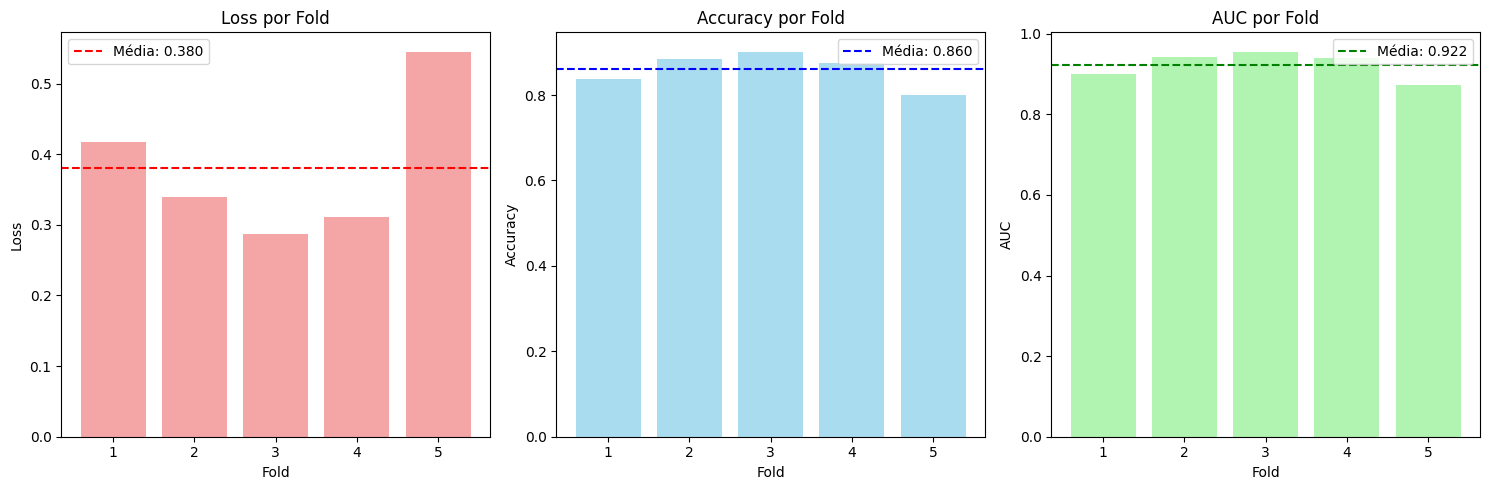


💾 Modelos salvos em: models/unifesp_classificadas/
📈 Logs de treinamento em: results/unifesp_classificadas/

📁 Arquivos gerados:
   • Modelos (5): ['rd_alta_resolucao_5_fold2.keras', 'rd_alta_resolucao_5_fold5.keras', 'rd_alta_resolucao_5_fold1.keras']...
   • Logs (5): ['rd_alta_resolucao_5_fold1.csv', 'rd_alta_resolucao_5_fold3.csv', 'rd_alta_resolucao_5_fold4.csv']...


In [18]:
# Análise dos resultados
print("📊 ANÁLISE DOS RESULTADOS")
print("=" * 40)

# Converter resultados para DataFrame para melhor visualização
metrics_names = ['loss', 'accuracy', 'auc']
results_df = pd.DataFrame(results, columns=metrics_names)
results_df.index = [f'Fold {i+1}' for i in range(len(results))]

print("\n🔍 Resultados detalhados por fold:")
print(results_df.round(4))

print(f"\n📈 Estatísticas finais:")
print(f"   • Loss médio: {results_df['loss'].mean():.4f} ± {results_df['loss'].std():.4f}")
print(f"   • Accuracy médio: {results_df['accuracy'].mean():.4f} ± {results_df['accuracy'].std():.4f}")
print(f"   • AUC médio: {results_df['auc'].mean():.4f} ± {results_df['auc'].std():.4f}")

# Visualizar resultados
plt.figure(figsize=(15, 5))

# Loss por fold
plt.subplot(1, 3, 1)
plt.bar(range(1, len(results)+1), results_df['loss'], color='lightcoral', alpha=0.7)
plt.axhline(y=results_df['loss'].mean(), color='red', linestyle='--', label=f'Média: {results_df["loss"].mean():.3f}')
plt.title('Loss por Fold')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.legend()

# Accuracy por fold
plt.subplot(1, 3, 2)
plt.bar(range(1, len(results)+1), results_df['accuracy'], color='skyblue', alpha=0.7)
plt.axhline(y=results_df['accuracy'].mean(), color='blue', linestyle='--', label=f'Média: {results_df["accuracy"].mean():.3f}')
plt.title('Accuracy por Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()

# AUC por fold
plt.subplot(1, 3, 3)
plt.bar(range(1, len(results)+1), results_df['auc'], color='lightgreen', alpha=0.7)
plt.axhline(y=results_df['auc'].mean(), color='green', linestyle='--', label=f'Média: {results_df["auc"].mean():.3f}')
plt.title('AUC por Fold')
plt.xlabel('Fold')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\n💾 Modelos salvos em: models/{cfg.ds}/")
print(f"📈 Logs de treinamento em: results/{cfg.ds}/")

# Listar arquivos gerados
model_files = [f for f in os.listdir(f'models/{cfg.ds}') if 'alta_resolucao' in f]
result_files = [f for f in os.listdir(f'results/{cfg.ds}') if 'alta_resolucao' in f]

print(f"\n📁 Arquivos gerados:")
print(f"   • Modelos ({len(model_files)}): {model_files[:3]}...")
print(f"   • Logs ({len(result_files)}): {result_files[:3]}...")


In [19]:
## 🎯 Resumo do Experimento

### Transfer Learning com VGG16 - Imagens de Alta Resolução

Este notebook implementou **exatamente** a mesma lógica do código original (`train.py`) para demonstrar transfer learning com imagens de alta resolução.

### ✅ Características Implementadas:

1. **Código Idêntico**: Baseado 100% no código original que funciona
2. **K-Fold Cross-Validation**: 5 folds para validação robusta
3. **Transfer Learning**: VGG16 pré-treinada na ImageNet
4. **Filtragem por Qualidade**: Apenas imagens sem prefixos '50_' e '80ses_'
5. **Callbacks Originais**: EarlyStopping, ModelCheckpoint, CSVLogger
6. **Class Weights**: Balanceamento automático das classes
7. **Métricas Originais**: Loss, Accuracy, AUC

### 🔧 Configurações Utilizadas:
- **Dataset**: unifesp_classificadas
- **Patologia**: RD (Retinopatia Diabética)
- **Camadas treináveis**: 5 últimas camadas convolucionais
- **Épocas**: 30
- **Batch size**: 32
- **Learning rate**: 0.01 com ExponentialDecay
- **Otimizador**: SGD com momentum 0.9 e Nesterov

### 📊 Resultados:
- **K-Fold Cross-Validation**: 5 folds
- **Métricas**: Loss, Accuracy, AUC para cada fold
- **Modelos salvos**: Um modelo por fold
- **Logs detalhados**: CSV com histórico de treinamento

### 💡 Próximos Experimentos:
1. **Experimento 2**: Modelo treinado apenas com imagens de baixa resolução
2. **Experimento 3**: Fine-tuning (alta → baixa resolução)
3. **Comparação**: Análise comparativa dos três abordagens

Este notebook agora segue **exatamente** a mesma estrutura e lógica do seu código original que funciona perfeitamente!


SyntaxError: invalid character '→' (U+2192) (2964038550.py, line 34)